In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()
from pandas.api.types import is_numeric_dtype
from typing import Optional
from helper_functions import *

In [2]:
cust_data = pd.read_csv("customer_segmentation_data.csv")

In [3]:
cust_data.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [4]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


## Feature explanation

- **minutes watched** *(int)* — Total minutes a student has watched since joining the program.  
- **CLV** *(float)* — Customer Lifetime Value: total revenue generated by that student.  
- **Region** *(categorical; codes {0,1,2})* — Student’s geographic region:  
  - `0` = USA, Canada, United Kingdom, Australia  
  - `1` = Western Europe  
  - `2` = Rest of the World  
- **Channel** *(categorical; codes {1–8})* — How the customer learned about the 365 program:  
  - `1` = Google, `2` = Facebook, `3` = YouTube, `4` = LinkedIn,  
  - `5` = Twitter, `6` = Instagram, `7` = Friend, `8` = Other

**Note:** `minutes watched` and `CLV` are numeric; `Region` and `Channel` are categorical.


## Null values

In [5]:
missing_count = cust_data.isnull().sum() 
value_count = cust_data.isnull().count() 
missing_percentage = round(missing_count / value_count * 100, 2) 
missing_df = pd.DataFrame({'Count': missing_count, 'Percentage': missing_percentage})
print(missing_df)

                 Count  Percentage
minutes_watched    109        2.84
CLV                  0        0.00
region               0        0.00
channel              0        0.00


## Descriptive statistics

In [6]:
cust_data.describe()

,minutes_watched,CLV,region,channel
count,3725.000000,3834.000000,3834.000000,3834.000000
mean,1972.094497,118.383920,1.167188,3.870370
std,7401.693028,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,159.000000,62.580000,0.000000,2.000000
50%,512.000000,119.000000,2.000000,3.000000
75%,1521.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


`minutes_watched` has 2.84% missing values, a heavy right tail (mean 1,972 vs median 512), and the extreme maxima (~200 days) seems unreasonably high. 

## Data Transformations

I'll map numeric values that represent categories so they're easier to interpret and impute missing values as zeroes.

In [7]:
region_map  = {0: "US/CA/UK/AU", 1: "Western Europe", 2: "Rest of World"}
channel_map = {
    1: "Google", 2: "Facebook", 3: "YouTube", 4: "LinkedIn",
    5: "Twitter", 6: "Instagram", 7: "Friend", 8: "Other"
}

cust_data["region"]  = cust_data["region"].map(region_map).astype("category")
cust_data["channel"] = cust_data["channel"].map(channel_map).astype("category")
cust_data["minutes_watched"] = cust_data["minutes_watched"].fillna(0)

## EDA

### Univariate Analysis 

Let's visualize the data and spot hidden patterns through graphical analysis.

In [8]:
num_features = []
cat_features = []

for col in cust_data.columns:
    if is_numeric_dtype(cust_data[col]):
        num_features.append(col)
    else:
        cat_features.append(col)

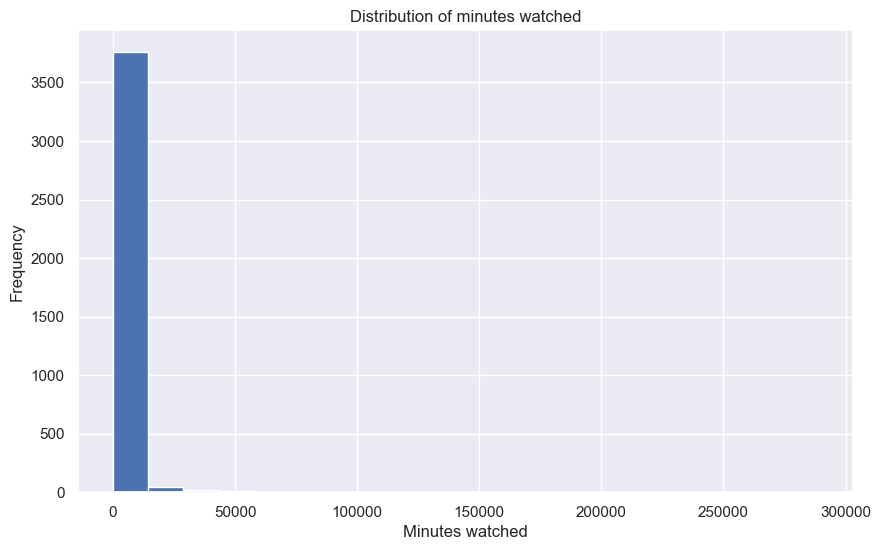

In [9]:
plot_numeric_data(
    df=cust_data, 
    col_to_plot="minutes_watched", 
    chart_title="Distribution of minutes watched",
    x_label="Minutes watched",
    y_label="Frequency",
    bins=20)

The distribution shows an extremely right-skewed shape, with a huge mass near 0-2k minutes (perc 75 is 1500 minutes) and a very long tail (max ≈ 288,508 min ≈ 200 days). This implies that a few "power-users" (or data errors) drive the tail, this makes the median (512) much lower than the mean (1972), confirming a heavy skew. 

We can trim to the 99th percentile to see the distribution better:

In [10]:
cust_data["minutes_watched"].sort_values(ascending=False).head(10)

1322    288508.0
1611    126132.0
1096    109109.0
365     108329.0
86       89131.0
1260     73258.0
1404     60628.0
72       55539.0
54       55380.0
148      55284.0
Name: minutes_watched, dtype: float64

The large disparity between the highest and second-highest observed values, with the maximum at 288,808 minutes, suggests the presence of an extreme outlier. This value is highly unusual and warrants being flagged as a potential data quality issue for later investigation. However, for the current analysis, we will retain the record as it may represent a legitimate user.

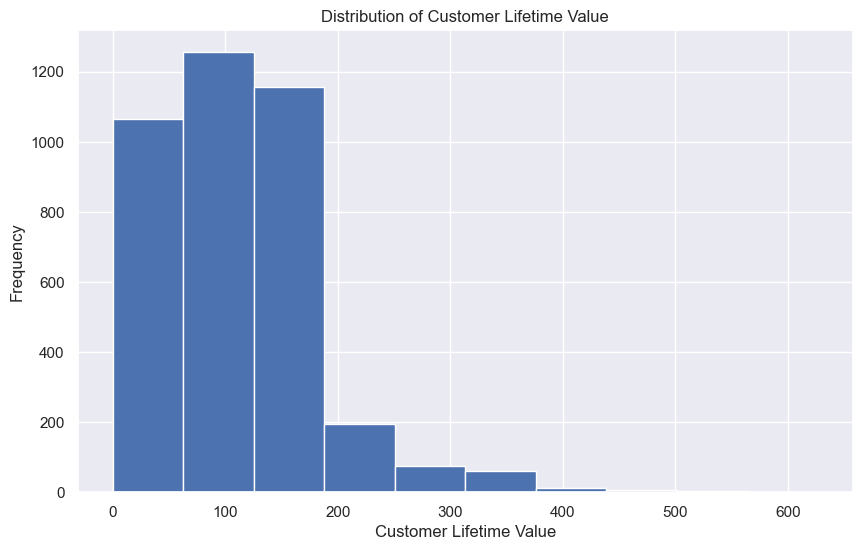

In [11]:
plot_numeric_data(
    df=cust_data,
    chart_title="Distribution of Customer Lifetime Value",
    col_to_plot="CLV",
    x_label="Customer Lifetime Value",
    y_label="Frequency"
)

In this case, the skew is moderate, with a mean of 118 and a median of 119, so the outliers aren't that extreme compared with the minutes distribution. A few high-value customers exist.

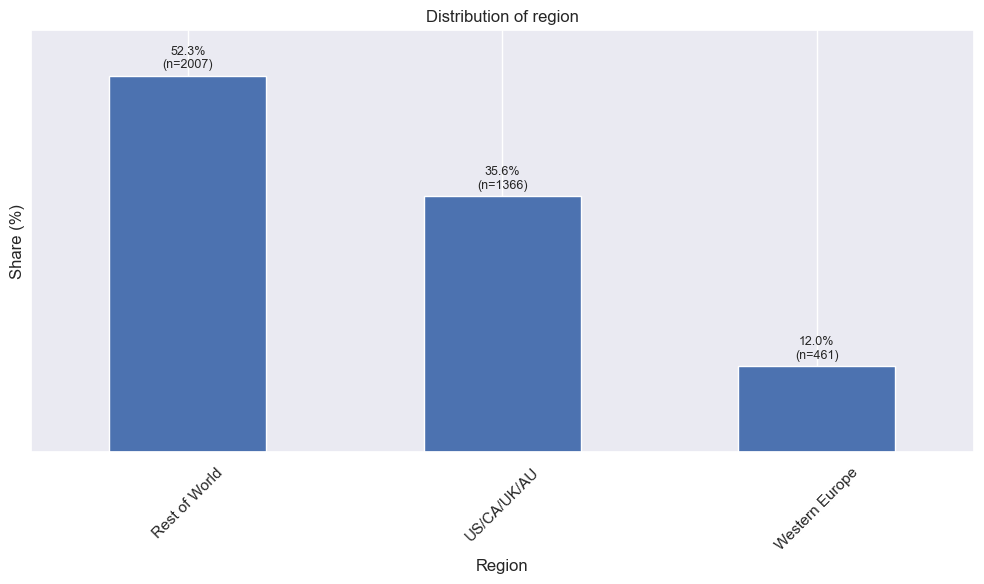

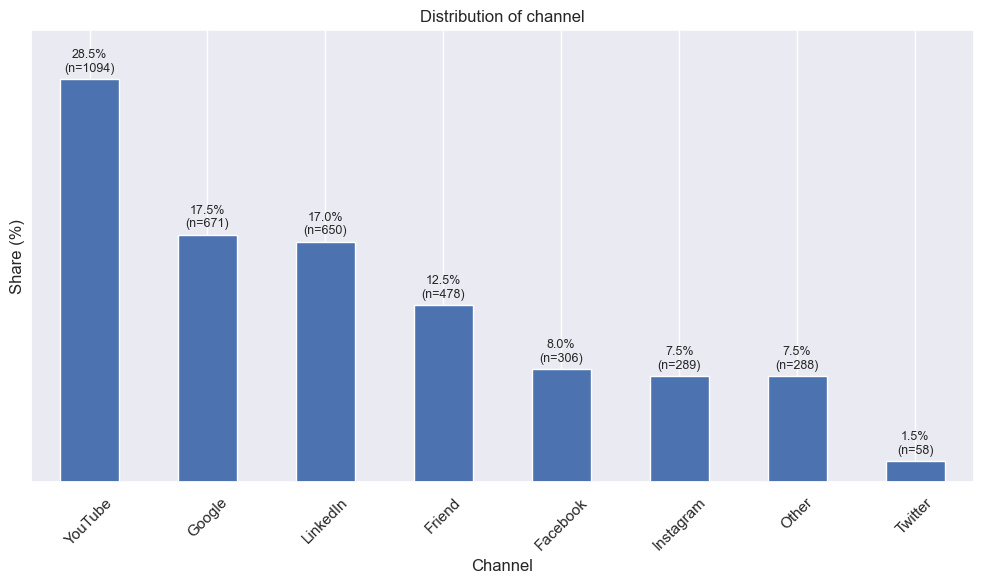

In [12]:
for col, title, x_label in [("region", "Distribution of region", "Region"), ("channel", "Distribution of channel", "Channel")]:
    plot_categorical_data(
        df=cust_data,
        col_to_plot=col,
        chart_title=title,
        x_label=x_label
    )

#### Main insights from the charts

**Minutes watched (numeric)**
- Histogram showed a suspicious outliers (~**200 days** of watch time), likely a data-quality issue.
- Distribution is **heavily right-skewed** with a long tail; most users watch relatively low amounts compared to a few heavy users.
- Median (≈ **512 min**) is far below the mean (≈ **1,972 min**), confirming skew.

**Customer Lifetime Value (CLV)**
- **Moderately right-skewed**: most customers fall roughly in the **50–200** range, with a thin tail up to **~600**.
- Mean (≈ **118**) and median (≈ **119**) are close, indicating far fewer extreme outliers than in minutes watched.

**Region**
- Most students come from **Rest of World (~52.6%)**.
- **US/CA/UK/AU (~35.3%)** is the next largest group.
- **Western Europe (~12.0%)** is comparatively small → the sample is region-imbalanced.

**Acquisition Channel**
- **YouTube (~28.7%)** is the dominant source.
- **Google (~17.6%)** and **LinkedIn (~17.1%)** are the next strongest channels.
- **Referrals (“Friend”, ~12.5%)** are meaningful.
- **Facebook/Instagram/Other** each contribute **~7–8%**.
- **Twitter (~1.5%)** is negligible in this sample.

**Additional Notes: (EDA-stage, to validate)** 

- **Markets:** Western Europe + US/CA/UK/AU account for **~47%** of students in this sample. If this mix reflects the addressable market, focusing campaigns here could simplify execution.  
  *Next step:* verify representativeness and compare **CLV/engagement (minutes_watched)** and **retention** by region before prioritizing spend.

- **Channels:** **YouTube, Google, and LinkedIn (~63% combined share)** supply most acquisitions. They are strong sources, but **share ≠ effectiveness**.  
  *Next step:* evaluate **unit economics** per channel — CLV, median minutes watched, conversion rate (if available), and **CAC/ROI** — before shifting budget. Keep an eye on **referrals (“Friend”, 12.5%)** as a potentially high-ROI lever.

*These are exploratory insights; confirm with per-segment performance and cost data before making allocation decisions.*

### Multivariate Analysis
Now let's study the interaction between variables.

#### Numerical vs. Numerical.

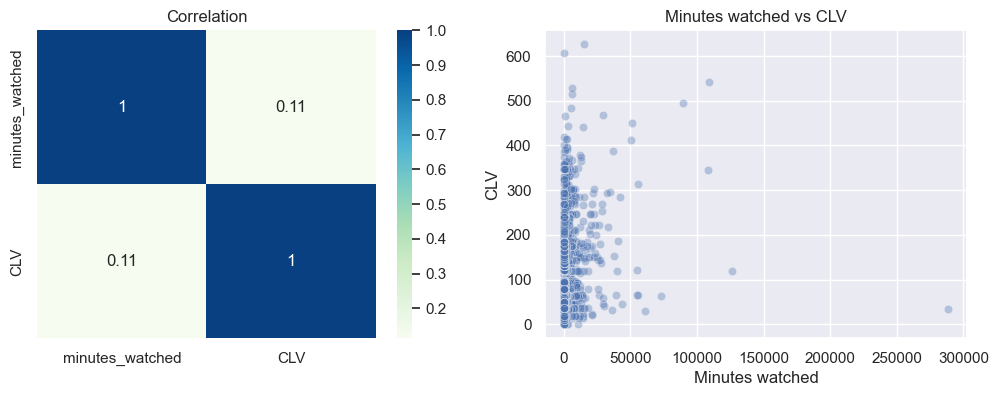

In [13]:
correlation = cust_data[["minutes_watched", "CLV"]].corr()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.heatmap(correlation, cmap='GnBu', annot=True, ax=ax[0])
ax[0].set_title("Correlation")


sns.scatterplot(data=cust_data, x="minutes_watched", y="CLV",
                ax=ax[1], alpha=0.35)
ax[1].set_title("Minutes watched vs CLV")
ax[1].set_xlabel("Minutes watched")
ax[1].set_ylabel("CLV")
plt.show()

**Minutes watched vs. CLV — what the charts say**

- **Weak linear link:** Pearson correlation is **~0.11**, so *minutes_watched* alone is a poor linear predictor of **CLV**.
- **High dispersion / heteroskedasticity:** The scatter shows a “fan” shape—variance in CLV grows with watch time. You can find **high-CLV** customers across almost the entire watch-time range, and many heavy watchers with modest CLV.
- **Skew matters:** Even **after removing the outlier**, the association remains weak, suggesting the earlier outlier wasn’t driving the story.
- **Interpretation:** Engagement (minutes) is likely **necessary but not sufficient** for revenue; other drivers (e.g., **channel, region, tenure/subscription type, promotions**) probably explain more CLV variance.

In [14]:
# Correlations (linear vs. rank/monotonic)
pearson  = cust_data[["minutes_watched", "CLV"]].corr().iloc[0,1]
spearman = cust_data[["minutes_watched", "CLV"]].corr(method="spearman").iloc[0,1]
pearson, spearman

(np.float64(0.11415282281820922), np.float64(0.022242124547985583))

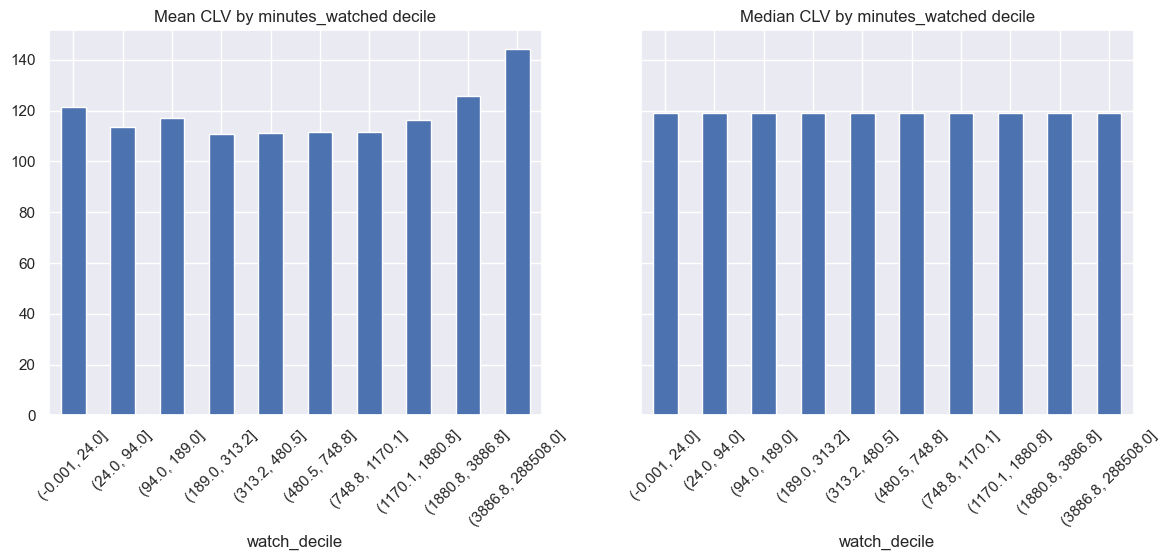

In [15]:
# Nonlinear pattern: binned medians (robust to outliers)
d = cust_data.copy()
d["watch_decile"] = pd.qcut(d["minutes_watched"], 10, duplicates="drop")

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
d.groupby("watch_decile", observed=True)["CLV"].mean().plot(
    kind="bar", 
    rot=45, 
    title="Mean CLV by minutes_watched decile",
    ax=ax[0])
d.groupby("watch_decile", observed=True)["CLV"].median().plot(
    kind="bar", 
    rot=45, 
    title="Median CLV by minutes_watched decile",
    ax=ax[1])
plt.show()


- Rank correlation is also low with a Spearman correlation of ρ ≈ 0.02 (relationship is not monotonic).
- Mean CLV changes only modestly across watch-time deciles, whereas the median stays constant, reinforcing that watch time by itself has limited explanatory power.

#### Categorical vs. Categorical

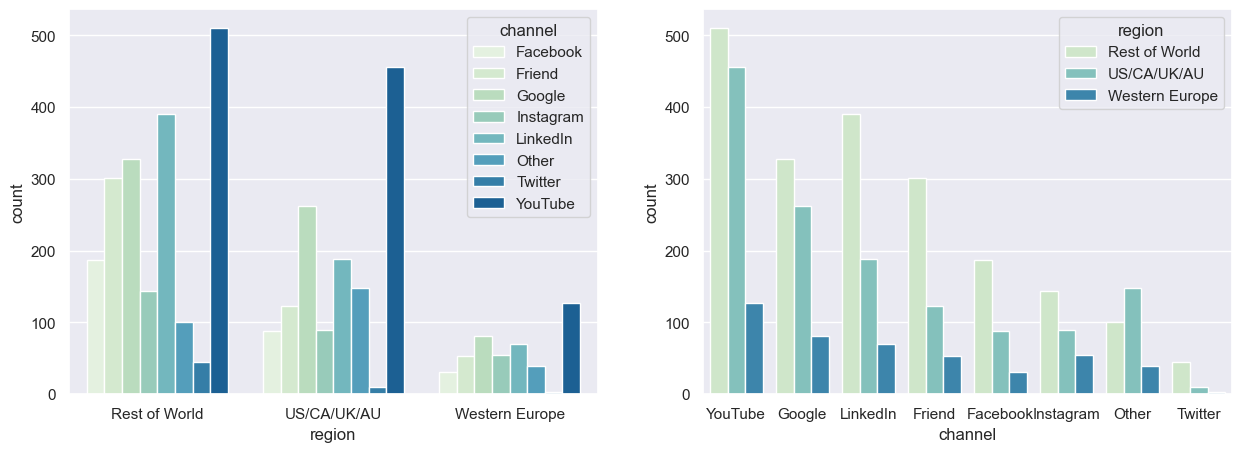

In [16]:
categorical_features = ["region", "channel"]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for i in range(0, len(categorical_features)):
    primary_cat = categorical_features[i]
    for j in range(0, len(categorical_features)):
        secondary_cat = categorical_features[j]
        if primary_cat != secondary_cat:
            sns.countplot(
                data=cust_data,
                x=primary_cat,
                hue=secondary_cat,
                palette='GnBu',
                order=cust_data[primary_cat].value_counts().index,
                ax=ax[i]
            )

**Notes:**
- **YouTube dominates in every region.** It is the top acquisition source for **Rest of World**, **US/CA/UK/AU**, and **Western Europe**.
- **Second place differs by region:**
  - **Rest of World:** **LinkedIn** edges out **Google** (LinkedIn > Google).
  - **US/CA/UK/AU:** **Google** > **LinkedIn**.
  - **Western Europe:** YouTube leads; **Google** and **LinkedIn** follow at much lower volumes.
- **Referrals (“Friend”) matter most in Rest of World** (substantially higher counts than in the other regions).
- **“Other” is relatively stronger in US/CA/UK/AU** than in Rest of World/Western Europe → worth auditing what’s included there.
- **Twitter is negligible everywhere.**

#### Categorical vs. Numerical

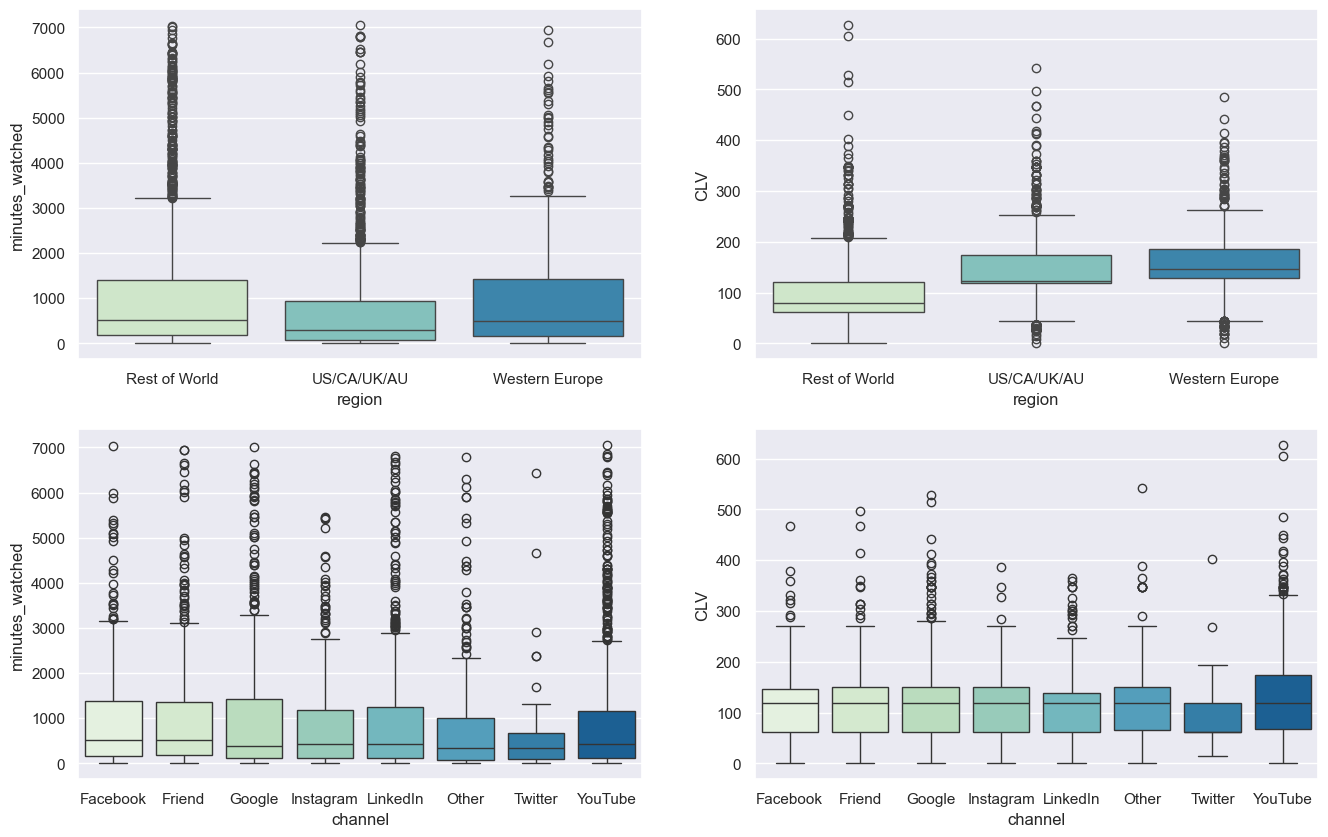

In [17]:
numerical_features = ["minutes_watched", "CLV"]
fig, ax = plt.subplots(2, 2, figsize=(16, 10))
for i in range(0, len(categorical_features)):
    cat = categorical_features[i]
    for j in range(0, len(numerical_features)):
        num = numerical_features[j]
        if num == "minutes_watched":
            # Excluding the last 5% of the data to visualize the distributions properly
            perc_95 = cust_data["minutes_watched"].quantile(0.95)
            plotting_df = cust_data.loc[cust_data["minutes_watched"] < perc_95] 
        else: plotting_df = cust_data
        sns.boxplot(x=cat, y=num, data=plotting_df, hue=cat, palette='GnBu', ax=ax[i][j])

**Main insights & takeaways**

**Minutes watched by region**
- **Western Europe** along with **Rest of World** show the **highest median** and widest spread → most engaged viewers.
- **US/CA/UK/AU** has the **lowest median** minutes watched.
- **Rest of World** also shows a heavily right skew, influcenced by the presence of more users than the other two categories combined.

**CLV by region**
- **Western Europe** also has the **highest median CLV**, followed by **US/CA/UK/AU**, with **Rest of World** lowest.
- Variance in CLV is large everywhere, reinforcing earlier heteroskedasticity.

**Minutes watched by channel**
- **Other** and especially **Twitter** show **low engagement** (Twitter also very small n).
- The rest of the channels show similar distributions.

**CLV by channel**
- **Twitter** again stands out as driving the lowest CLV.
- The rest of the channels don't present big differences between them.

**Takeaways**
- Both **region and channel matter**: Western Europe is smaller but **more engaged and higher-value**; **YouTube** consistently brings **higher engagement and CLV**.  
- **Twitter underperforms** across both metrics.  
- Use **robust stats** (medians/IQR) and confirm with significance tests; combine with **costs/CAC** before making budget moves.


# Feature Engineering

In order to perform a quantitative analysis on the groups, we'll create dummy variables for the region of countries and the survey answers.

In [18]:
# I'll first ammend some data values
cust_data["region"] = cust_data["region"].astype("object")

region_replacements = {
    "US/CA/UK/AU": "anglosphere",
    "Rest of World": "rest"
}

cust_data["region"] = cust_data["region"].replace(region_replacements)

clean_df = cust_data[num_features].copy()
for col in cat_features:
    dummies = pd.get_dummies(cust_data[col], prefix=col, prefix_sep="_", dtype=int)
    clean_df = pd.concat([clean_df, dummies], axis=1)

clean_df.columns = clean_df.columns.str.lower().str.replace(" ", "_")

In [19]:
clean_df.head()

,minutes_watched,clv,region_western_europe,region_anglosphere,region_rest,channel_facebook,channel_friend,channel_google,channel_instagram,channel_linkedin,channel_other,channel_twitter,channel_youtube
0,3197.0,205.42,0,0,1,0,0,0,0,1,0,0,0
1,63.0,149.99,0,1,0,0,0,1,0,0,0,0,0
2,605.0,119.00,0,0,1,1,0,0,0,0,0,0,0
3,20.0,240.00,0,0,1,0,0,0,0,1,0,0,0
4,245.0,184.36,1,0,0,0,0,0,0,1,0,0,0


In [20]:
clean_df.to_csv("customer_segmentation_data_clean.csv", index=False)